# CAB320 Assignment 2 - Transfer Learning
Anthony Vanderkop, Thierry Peynot, Frederic Maire (Jupyter Notebook template: 2025)


## Instructions:
The functions and classes defined in this module will be called by the marker without modification. 
You should complete the functions and classes according to their specified interfaces.

No partial marks will be awarded for functions that do not meet the specifications of the interfaces.


In [38]:
### LIBRARY IMPORTS ###
import os
import numpy as np
import keras
import keras.applications as ka
import matplotlib.pyplot as plt

## Task 1
Implement the my_team()function 

In [39]:
def my_team():
    """
    Return the list of the team members of this assignment submission as a list
    of triplet of the form (student_number, first_name, last_name)

    """
    return [ (11032553, 'Hunter', 'Wilde'), (12026395, 'Oliver', 'Kele') ]

In [40]:
my_team()

[(11032553, 'Hunter', 'Wilde'), (12026395, 'Oliver', 'Kele')]

## Task 2
Download the small_flower_dataset from Canvas and load the data

In [41]:
# Global variable to store class name to index mapping
class_to_idx = {}

def load_data(path):
    """
    Load in the dataset from its home path. Path should be a string of the path
    to the home directory the dataset is found in. Should return numpy arrays
    with paired images and class labels.

    This function:
    1. Loads images from the small_flower_dataset directory structure
        - The dataset is organized with class folders, where folder name = class name
    2. Organizes them into features (X) and labels (Y)
    3. Returns tuple of (X, Y) where:
       - X is a numpy array of images with shape (n_samples, height, width, channels)
       - Y is a numpy array of integer labels with shape (n_samples,)
    """

    X = []
    Y = []

    # Get the global variable class_to_idx
    global class_to_idx

    # Get all subdirectories (class folders) in the path
    class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    # Clear the existing dictionary and assign new integer indices to each class
    class_to_idx.clear()
    for idx, class_name in enumerate(sorted(class_dirs)):
        class_to_idx[class_name] = idx

    # Set target size for MobileNetV2 and to account for different image sizes in dataset
    target_size = (224, 224)

    # Process each class directory
    for class_name in class_dirs:
        class_path = os.path.join(path, class_name)
        class_idx = class_to_idx[class_name]

        # Get all image files in the class directory
        image_files = os.listdir(class_path)

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            # Load image and convert to array with target size of 224x224 (MobileNetV2 input size)
            img = keras.utils.load_img(img_path, target_size=target_size)
            img_array = keras.utils.img_to_array(img)

            # Add to dataset
            X.append(img_array)
            Y.append(class_idx)

    # Convert lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Printf statements to check the dataset has been loaded correctly 
    print(f"Dataset loaded: {X.shape[0]} images, {len(class_to_idx)} classes")
    print(f"Image shape: {X.shape[1:]}")
    print(f"Classes: {class_to_idx}")

    return X, Y

In [42]:
X, Y = load_data("./small_flower_dataset")

Dataset loaded: 1000 images, 5 classes
Image shape: (224, 224, 3)
Classes: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


## Task 3
Prepare your training, validation and test sets for the non-accelerated version of transfer learning.

In [43]:
def split_data(X, Y, train_fraction, randomize=False, eval_set=True):
    """
    Split the data into training and testing sets. If eval_set is True, also create
    an evaluation dataset. There should be two outputs if eval_set is False, or
    three outputs (train, test, eval) if eval_set is True.

    This function performs stratified splitting to maintain class balance, ensuring
    each split contains the same proportion of samples from each class.

    Parameters:
    -----------
    X : numpy.array
        Array of image data with shape (n_samples, height, width, channels)
    Y : numpy.array
        Array of class labels with shape (n_samples)
    train_fraction : float
        Fraction of data to use for training (between 0 and 1)
    randomize : bool, optional
        Whether to randomize the data before splitting (default: False)
    eval_set : bool, optional
        Whether to create a separate evaluation/validation set (default: True)

    Returns:
    --------
    If eval_set=True:
        (train_set, eval_set, test_set) : tuple of tuples
            Each inner tuple contains (images, labels) for the respective set
    If eval_set=False:
        (train_set, test_set) : tuple of tuples
            Each inner tuple contains (images, labels) for the respective set
    """
    # Get classes (known to be unique, but uses .unique() to catch any bugs/errors from earlier functions)
    unique_classes = np.unique(Y)

    # Lists to store indices for each split
    train_indices = []
    eval_indices = []
    test_indices = []

    # For each class, split its indices to maintain class balance
    for class_idx in unique_classes:
        # Get indices of samples belonging to this class
        class_indices = np.flatnonzero(Y == class_idx)
        num_samples = len(class_indices)

        # Randomize if requested
        if randomize:
            np.random.shuffle(class_indices)

        # Calculate split points
        train_end = int(num_samples * train_fraction)

        if eval_set:
            # Ensure equal sizes for validation and test sets
            remaining = num_samples - train_end
            val_samples = remaining // 2

            eval_end = train_end + val_samples

            # Add indices to respective sets
            train_indices.extend(class_indices[:train_end].tolist())
            eval_indices.extend(class_indices[train_end:eval_end].tolist())
            test_indices.extend(class_indices[eval_end:].tolist())
        else:
            # No eval set, just train and test
            train_indices.extend(class_indices[:train_end].tolist())
            test_indices.extend(class_indices[train_end:].tolist())

    # Convert lists to integer numpy arrays explicitly
    train_indices = np.array(train_indices, dtype=int)
    test_indices = np.array(test_indices, dtype=int)

    # Create the final datasets
    train_set = (X[train_indices], Y[train_indices])
    test_set = (X[test_indices], Y[test_indices])

    if eval_set:
        eval_indices = np.array(eval_indices, dtype=int)
        eval_set_data = (X[eval_indices], Y[eval_indices])

        # Print statement for debugging/check
        print(f"Split complete: {len(train_indices)} train, {len(eval_indices)} validation, {len(test_indices)} test images")
        return train_set, eval_set_data, test_set
    else:
        # Print statement for debugging/check
        print(f"Split complete: {len(train_indices)} train, {len(test_indices)} test images")
        return train_set, test_set

In [44]:
train_set, eval_set, test_set = split_data(X, Y, train_fraction = 0.8)

Split complete: 800 train, 100 validation, 100 test images


Report: Include details of how you have split the data to perform this training. Ensure the split is reasonable and does not introduce class imbalance during training

The array of class labels `Y` is first passed through a function which extracts only unique entries to ensure there are no repeated classes; the filtered class array `unique_classes` is then iterated over as each entry in `Y` is assigned to a unique class, resulting in a local instance of `class_indices` for each unique class, which contains all entries of that class (should be 1, excepting anomalies). The set of classes is split between the arrays `train_set` & `test_set` according to the ratio assigned to `train_fraction`.

## Task 4
Using the tf.keras.applications module download a pretrained MobileNetV2 network. 

In [45]:
def load_model():
    """
    Load in a pretrained MobileNetV2 model using the keras.applications module.

    This function:
    1. Downloads a pretrained MobileNetV2 network with weights from ImageNet
    2. Sets up the model with the input shape appropriate for our dataset (224, 224, 3)
    3. Ensures the base model layers are not trainable (frozen) for transfer learning

    Returns:
    --------
    model : keras.Model
        A pretrained MobileNetV2 model with frozen base layers, ready for transfer learning
    """

    # Load the pretrained model without the top classification layer
    # Include weights from ImageNet, and use input shape of 224x224x3
    base_model = ka.MobileNetV2(weights='imagenet', 
                            include_top=False, 
                            input_shape=(224, 224, 3))

    # Freeze the layers in the base model so they won't be trained
    for layer in base_model.layers:
        layer.trainable = False

    # Print f statements to ensure model loaded correctly
    print(f"MobileNetV2 model loaded with {len(base_model.layers)} layers")
    print(f"Input shape: {base_model.input_shape}")
    print(f"Output shape: {base_model.output_shape}")

    return base_model

In [46]:
model = load_model()

MobileNetV2 model loaded with 154 layers
Input shape: (None, 224, 224, 3)
Output shape: (None, 7, 7, 1280)


## Task 5
Replace the last layer of the downloaded neural network with a Dense layer of the appropriate shape for the 5 classes of the small flower dataset {(x1,t1), (x2,t2),..., (xm,tm)}.

## Task 6
Compile and train your model with an SGD optimizer using the following parameters learning_rate=0.01, momentum=0.0, nesterov=False. (NB: The SGD class description can be found at https://keras.io/api/optimizers/sgd/  )

In [47]:
def transfer_learning(train_set, eval_set, model, parameters=(0.01, 0.0, False)):
    """
    Implement and perform standard transfer learning here.

    Inputs:
        - train_set: list or tuple of the training images and labels in the
            form (images, labels) for training the classifier
        - eval_set: list or tuple of the images and labels used in evaluating
            the model during training, in the form (images, labels)
        - model: an instance of tf.keras.applications.MobileNetV2
        - parameters: tuple of parameters to use during training:
            (learning_rate, momentum, nesterov)

    Outputs:
        - model : an instance of tf.keras.applications.MobileNetV2

    """

    # Unpack parameters
    learning_rate, momentum, nesterov = parameters

    # Unpack datasets
    x_train, y_train = train_set
    x_eval, y_eval = eval_set

    # Get number of classes from the dataset
    num_classes = len(np.unique(y_train))

    # Add a global average pooling layer and a new classification layer
    x = model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    predictions = keras.layers.Dense(num_classes, 'softmax')(x)

    # Create the final model
    final_model = keras.models.Model(model.input, predictions)

    # Compile the model with specified parameters
    optimizer = keras.optimizers.SGD(learning_rate, momentum, nesterov)
    final_model.compile(
        optimizer,
        loss = 'sparse_categorical_crossentropy',  # Use for integer class labels
        metrics = ['accuracy']
    )

    # Define callbacks for training
    checkpoint = keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor = 'val_accuracy',
        save_best_only = True,
        mode = 'max',
        verbose = 1
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 10,  # Number of epochs with no improvement after which to stop
        restore_best_weights = True,
        verbose = 1
    )

    # Train the model
    history = final_model.fit(
        x_train, y_train,
        validation_data = (x_eval, y_eval),
        epochs = 50,  # Can be adjusted
        batch_size = 32,  # Can be adjusted
        callbacks = [checkpoint, early_stopping],
        verbose = 1
    )

    # Store the training history as an attribute for later analysis
    final_model.history = history

    return final_model

In [48]:
model_trained = transfer_learning(train_set, eval_set, model)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.1855 - loss: 1.9863
Epoch 1: val_accuracy improved from -inf to 0.31000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.1867 - loss: 1.9809 - val_accuracy: 0.3100 - val_loss: 1.5739
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3666 - loss: 1.5421
Epoch 2: val_accuracy improved from 0.31000 to 0.39000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.3663 - loss: 1.5423 - val_accuracy: 0.3900 - val_loss: 1.4367
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.4022 - loss: 1.4246
Epoch 3: val_accuracy did not improve from 0.39000
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.4016 - loss: 1.4252 - val_accuracy: 0.3600 - val_loss: 1.5294
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4329 - loss: 1.3609
Epoch 4: val_accuracy improved from 0.39000 to 0.41000, saving model to best_m

Report: Provide an overview of the function and how it works.

After first unpacking all necessary data from the input parameters, two new layers (a GAP layer & a softmax classification layer) are added to the model, which are derived from the output of the model's previous version. The new model is compiled, reusing the input parameters given for the previous model. Checkpoints & early stopping points are defined for time-saving during training. Finally, the previous version of the model is appended to the model history.

## Task 7
Plot the training and validation errors and accuracies of standard transfer 

In [49]:
def plot_errors(model):
    """
    Plot the training & validation errors & accuracies from the model's training history.

    This function:
    1. Creates two subplots: one for error & one for accuracy.
    2. Plots both training & validation metrics on each subplot.
    3. Adds appropriate labels, titles, & legend.
    """
    # Unpack the model history & epochs
    history = model.history.history
    epochs = model.history.epoch

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation error
    ax1.plot(epochs, history['loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation accuracies
    ax2.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

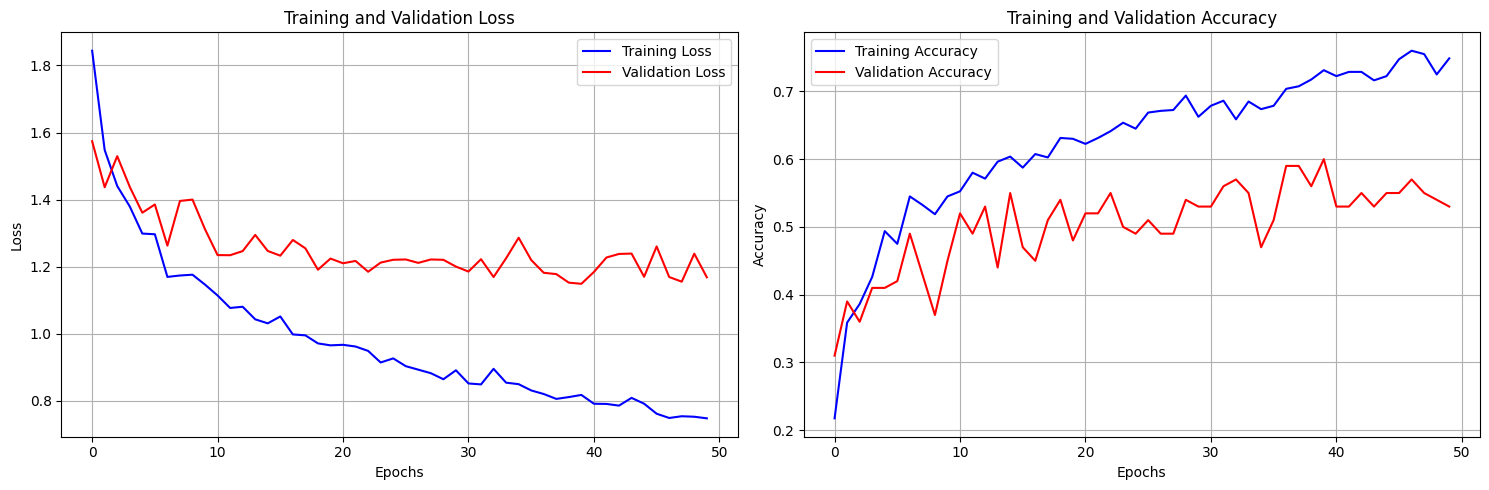

In [51]:
plot_errors(model_trained)

## Task 8
Experiment with 3 different orders of magnitude for the learning rate. Plot the results and discuss in the below markdown cell

In [56]:
model_slowest = transfer_learning(train_set, eval_set, model, (0.00001, 0.0, False))# 1/1000x the base learning rate
model_slower = transfer_learning(train_set, eval_set, model, (0.001, 0.0, False))   # 1/10x the base learning rate
model_faster = transfer_learning(train_set, eval_set, model, (10.0, 0.0, False))    # 1000x the base learning rate

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2418 - loss: 1.8369
Epoch 1: val_accuracy improved from -inf to 0.13000, saving model to best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 452ms/step - accuracy: 0.2408 - loss: 1.8370 - val_accuracy: 0.1300 - val_loss: 1.9604
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.2190 - loss: 1.8649
Epoch 2: val_accuracy did not improve from 0.13000
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.2189 - loss: 1.8636 - val_accuracy: 0.1300 - val_loss: 1.9502
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.2025 - loss: 1.8183
Epoch 3: val_accuracy did not improve from 0.13000
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.2030 - loss: 1.8184 - val_accuracy: 0.1300 - val_loss: 1.9407
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2253 - loss: 1.8003
Epoch 4: val_accuracy did not improve from 0.13000
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - accuracy: 0.2247 - 

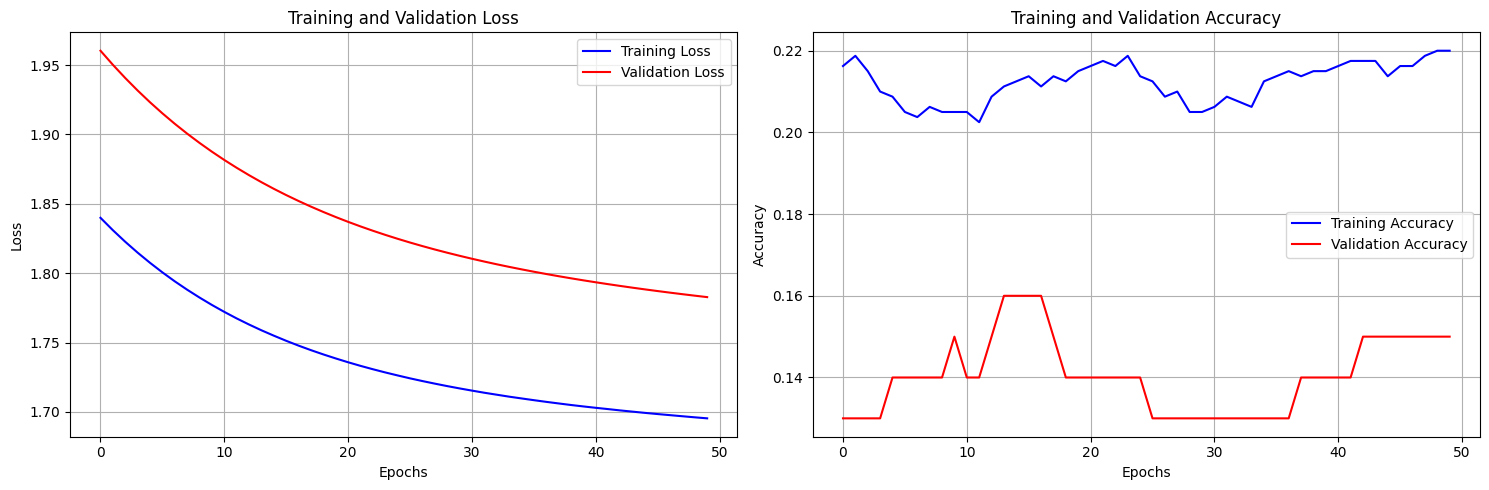

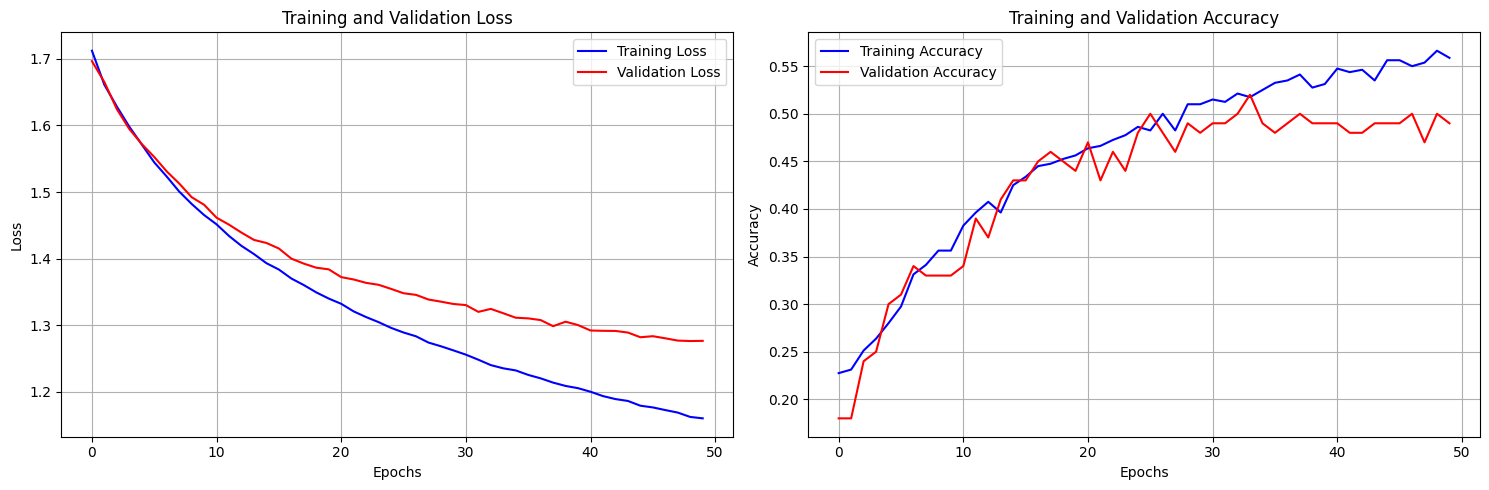

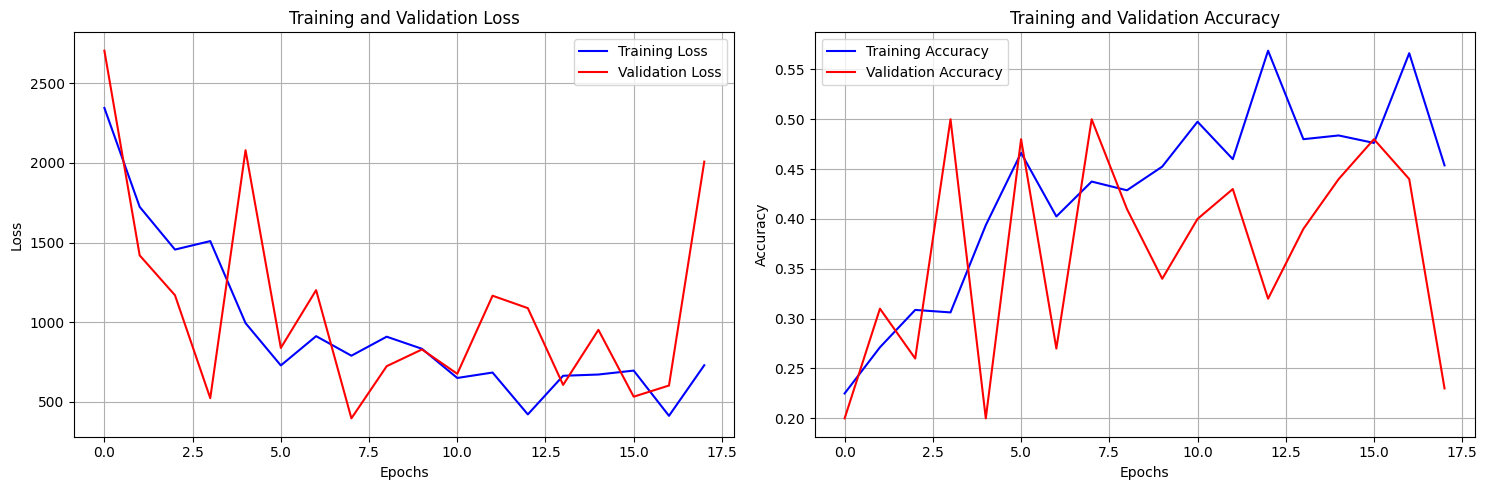

In [57]:
# Plotting the results
plot_errors(model_slowest)
plot_errors(model_slower)
plot_errors(model_faster)

### Task 8 Analysis and discussion


With a faster learning rate, the training & validation data becomes erratic, although a perceptible trend is that maximum loss appears to be proportional to learning rate. As the learning rate is decreased, loss approaches a perfectly smooth parabolic curve; the shape of these curves stay about the same, but the values at all points increase with slower learning rates (while the increase is slightly when compared to the faster learning rate). Accuracy also resembles a parabolic curve in the opposite direction. We also see a separation emerge between the training & validation loss curves, with validation loss being the higher. Such a separation can also be seen in the training & validation accuracies for the slowest learning rate; accuracies for this rate appear to plateau rather than follow a curve, staying around the initial values seen for faster learning rates.

To minimise loss & maximise accuracy, learning rates close to the base rate would appear to be the best option. The base learning rate exhibits better results than any of these experiments.

## Task 9
Run the resulting classifier on your test dataset using results from the best learning rate you experimented with. Compute and display the confusion matrix. 

In [ ]:
## Your code

## Task 10
Compute the precision, recall, and f1 scores of your classifier on the test dataset using the best learning rate. Report on the results and comment. 

In [ ]:
## Your code

## Task 11
Perform k-fold validation on the dataset with k = 3. 

In [ ]:
def k_fold_validation(features, ground_truth, classifier, k=2):
    """
    Inputs:
        - features: np.ndarray of features in the dataset
        - ground_truth: np.ndarray of class values associated with the features
        - fit_func: f
        - classifier: class object with both fit() and predict() methods which
        can be applied to subsets of the features and ground_truth inputs.
        - predict_func: function, calling predict_func(features) should return
        a numpy array of class predictions which can in turn be input to the
        functions in this script to calculate performance metrics.
        - k: int, number of sub-sets to partition the data into. default is k=2
    Outputs:
        - avg_metrics: np.ndarray of shape (3, c) where c is the number of classes.
        The first row is the average precision for each class over the k
        validation steps. Second row is recall and third row is f1 score.
        - sigma_metrics: np.ndarray, each value is the standard deviation of
        the performance metrics [precision, recall, f1_score]
    """

    #split data
    ### YOUR CODE HERE ###

    #go through each partition and use it as a test set.
    for partition_no in range(k):
        #determine test and train sets
        ### YOUR CODE HERE###

        #fit model to training data and perform predictions on the test set
        classifier.fit(train_features, train_classes)
        predictions = classifier.predict(test_features)

        #calculate performance metrics
        ### YOUR CODE HERE###

    #perform statistical analyses on metrics
    ### YOUR CODE HERE###

    raise NotImplementedError
    return avg_metrics, sigma_metrics

In [ ]:
## Your code
# xx = k_fold_validation(xx, xx, xx, xx)

Comment on the results and any differences with the previous test-train split. 
Repeat with two different values for k and comment on the results. 

### Comments and analysis

## Task 12
With the best learning rate that you found in the previous task, add a non-zero momentum to the training with the SGD optimizer (consider 3 values for the momentum). Report on how your results change.  

In [ ]:
## Code

### Report

## Task 13
Now using “accelerated transfer learning”, repeat the training process (k-fold validation is optional this time). You should prepare your training, validation and test sets based on {(F(x1).t1), (F(x2),t2),...,(F(xm),tm)}, and re-do Task 12. 


In [ ]:
def accelerated_learning(train_set, eval_set, model, parameters):
    """
    Implement and perform accelerated transfer learning here.

    Inputs:
        - train_set: list or tuple of the training images and labels in the
            form (images, labels) for training the classifier
        - eval_set: list or tuple of the images and labels used in evaluating
            the model during training, in the form (images, labels)
        - model: an instance of tf.keras.applications.MobileNetV2
        - parameters: list or tuple of parameters to use during training:
            (learning_rate, momentum, nesterov)


    Outputs:
        - model : an instance of tf.keras.applications.MobileNetV2

    """
    raise NotImplementedError
    return model


Plot and comment on the results and differences against the standard implementation of transfer learning. 

In [ ]:
## Code

### Your Comments:

## Task 14
Use the results of all experiments to make suggestions for future work and recommendations for parameter values to anyone else who may be interested in a similar implementation of transfer learning. 

### Your answer: